In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
originalData = pd.read_csv("./bs_dataset.csv")
originalData.tail(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0
594642,179,'C616528518','4','F','28007','M1823072687','28007','es_transportation',26.93,0


In [31]:
originalData.isnull().values.any()

False

In [32]:
for column in originalData.columns:
  no_of_null = originalData[column].isnull().sum()
  print('Column: {column}'.format(column=column))
  print('No of nulls/NaN: {no_of_null}'.format(no_of_null=no_of_null))
  print()


# category, amount and fraud have null values

Column: step
No of nulls/NaN: 0

Column: customer
No of nulls/NaN: 0

Column: age
No of nulls/NaN: 0

Column: gender
No of nulls/NaN: 0

Column: zipcodeOri
No of nulls/NaN: 0

Column: merchant
No of nulls/NaN: 0

Column: zipMerchant
No of nulls/NaN: 0

Column: category
No of nulls/NaN: 0

Column: amount
No of nulls/NaN: 0

Column: fraud
No of nulls/NaN: 0



In [33]:
# to drop NA
originalData = originalData.dropna()

# Data preprocessing

In [34]:
print(originalData.dtypes)

originalData = originalData.loc[originalData["age"] != "'U'" ]

# remove quotes
originalData['age'] = originalData['age'].str.replace("'", '')
originalData['gender'] = originalData['gender'].str.replace("'", '')


# remove the "U" and "E"
originalData = originalData.loc[originalData["age"] != "U" ]
originalData = originalData.loc[originalData["gender"] != "U"]
originalData = originalData.loc[originalData["gender"] != "E"]

# Convert age into integer
originalData = originalData.astype({'age':'int'})
print(originalData[['age','gender']].head())



step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object
   age gender
0    4      M
1    2      M
2    4      F
3    3      M
4    5      M


# Encoding (Hot and label)

In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
temp = originalData.copy()

labelencoder = LabelEncoder()
temp = originalData

# Hot encode gender
temp['gender_encoded'] = labelencoder.fit_transform(originalData['gender'])


# Label encode customer, zipcodeOri, merchant and category
temp['customer_encoded'] = labelencoder.fit_transform(originalData['customer'])
temp['zipcodeOri_encoded'] = labelencoder.fit_transform(originalData['zipcodeOri'])
temp['merchant_encoded'] = labelencoder.fit_transform(originalData['merchant'])
temp['zipMerchant_encoded'] = labelencoder.fit_transform(originalData['zipMerchant'])
temp['category_encoded'] = labelencoder.fit_transform(originalData['category'])

temp.head()
temp.columns
temp = temp.drop(columns=['customer', 'gender','zipcodeOri','merchant','zipMerchant','category'])
temp.head()

,step,age,amount,fraud,gender_encoded,customer_encoded,zipcodeOri_encoded,merchant_encoded,zipMerchant_encoded,category_encoded
0,0,4,4.55,0,1,210,0,30,0,12
1,0,2,39.68,0,1,2746,0,30,0,12
2,0,4,26.89,0,0,2280,0,18,0,12
3,0,3,17.25,0,1,1646,0,30,0,12
4,0,5,35.72,0,1,3578,0,30,0,12


In [36]:
# from seaborn import swarmplot

# data_to_plot = pd.melt(temp[['step', 'customer_encoded', 'age', 'gender_encoded','zipcodeOri_encoded','zipMerchant_encoded','category_encoded','amount']],
#                        var_name='features',
#                        value_name='fraud')

# print(data_to_plot.head())
# swarmplot(data=data_to_plot, x='features', y='fraud', hue='fraud');

# Train/Test Split

In [37]:
# train/test split
from sklearn.model_selection import train_test_split

temp2 = temp.copy()
y = temp['fraud']
X = temp2.drop(['fraud'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

In [38]:
print(X_train.shape)
print(X_test.shape)

(415065, 9)
(177885, 9)


## Gradient boosting classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Initialize classifier
gbc = GradientBoostingClassifier(max_depth=5, random_state=42)

# Train classifier using all features
gbc.fit(X_train, y_train)

# Make predictions
preds = gbc.predict(X_test)

# Evaluate the model using the F1-score
f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)

print(f1_score_all)

0.995


# Feature Selection Techniques

## Variance Threshold

In [40]:
X_train_v1, X_test_v1, y_tain_v1, y_test_v1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [41]:
X_train_v1.var(axis=0)

step                   2.606740e+03
age                    1.752797e+00
amount                 1.288169e+04
gender_encoded         2.477540e-01
customer_encoded       1.395833e+06
zipcodeOri_encoded     0.000000e+00
merchant_encoded       7.370967e+01
zipMerchant_encoded    0.000000e+00
category_encoded       7.927390e+00
dtype: float64

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

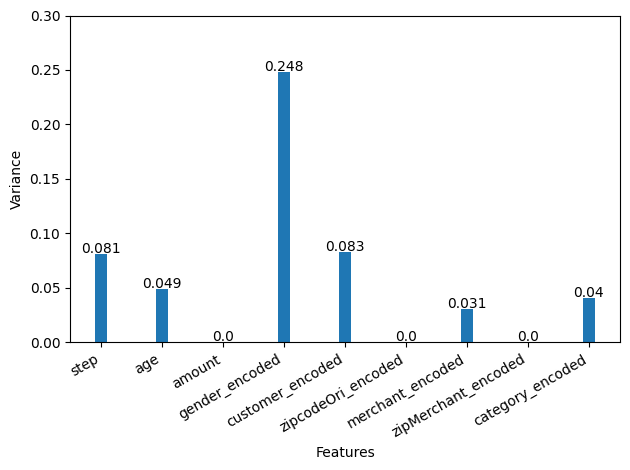

In [43]:
fig, ax = plt.subplots()

x = X.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

fig.autofmt_xdate()
plt.tight_layout()

### Can drop those with lower values (would say 0.03 and below)

In [44]:
sel_X_train_v1 = X_train_v1.drop(['amount','zipcodeOri_encoded',
                                 "zipMerchant_encoded"], axis=1)
sel_X_test_v1 = X_test_v1.drop(['amount','zipcodeOri_encoded',
                                 "zipMerchant_encoded"], axis=1)

gbc.fit(sel_X_train_v1, y_train)

var_preds = gbc.predict(sel_X_test_v1)

f1_score_var = round(f1_score(y_test_v1, var_preds, average='weighted'), 3)

print(f1_score_var)

0.993


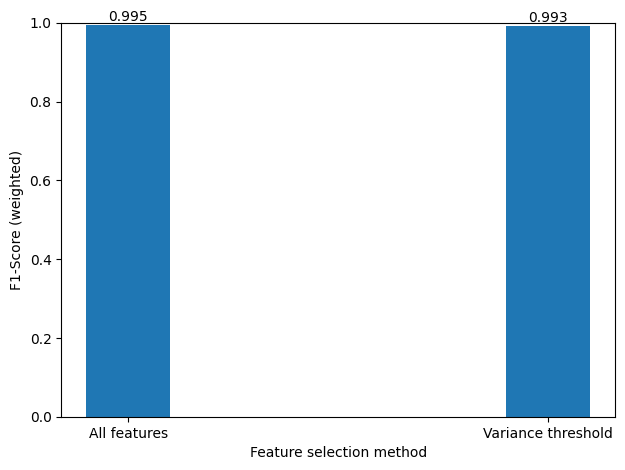

In [45]:
fig, ax = plt.subplots()

x = ['All features', 'Variance threshold']
y = [f1_score_all, f1_score_var]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.01, s=str(round(value,3)), ha='center')

plt.tight_layout()

## K-best features

In [46]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [47]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

f1_score_list = []

for k in range(1, 8):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_v2, y_train_v2)

    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)

    gbc.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = gbc.predict(sel_X_test_v2)

    f1_score_kbest = round(f1_score(y_test_v2, kbest_preds, average='weighted'), 3)

    f1_score_list.append(f1_score_kbest)

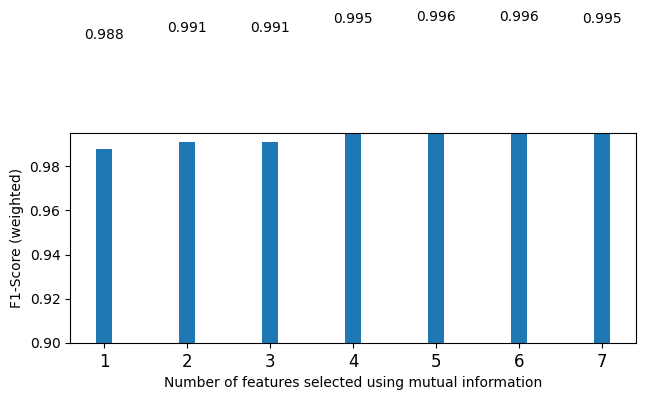

In [48]:
fig, ax = plt.subplots()

x = np.arange(1, 8)
y = f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using mutual information')
ax.set_ylabel('F1-Score (weighted)')

# apparently difference not too significant
ax.set_ylim(0.9, 0.995)
ax.set_xticks(np.arange(1, 8))
ax.set_xticklabels(np.arange(1, 8), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

# plt.figure(figsize=(1,1))
fig.tight_layout(pad=0.5)


In [49]:
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train_v2, y_train_v2)

selected_feature_mask = selector.get_support()

selected_features = X_train_v2.columns[selected_feature_mask]

selected_features

Index(['gender_encoded', 'merchant_encoded', 'category_encoded'], dtype='object')

## Recursive feature elimination (RFE)

In [50]:
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [51]:
from sklearn.feature_selection import RFE

rfe_f1_score_list = []

for k in range(1, 8):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_v3, y_train_v3)

    sel_X_train_v3 = RFE_selector.transform(X_train_v3)
    sel_X_test_v3 = RFE_selector.transform(X_test_v3)

    gbc.fit(sel_X_train_v3, y_train_v3)
    RFE_preds = gbc.predict(sel_X_test_v3)

    f1_score_rfe = round(f1_score(y_test_v3, RFE_preds, average='weighted'), 3)

    rfe_f1_score_list.append(f1_score_rfe)

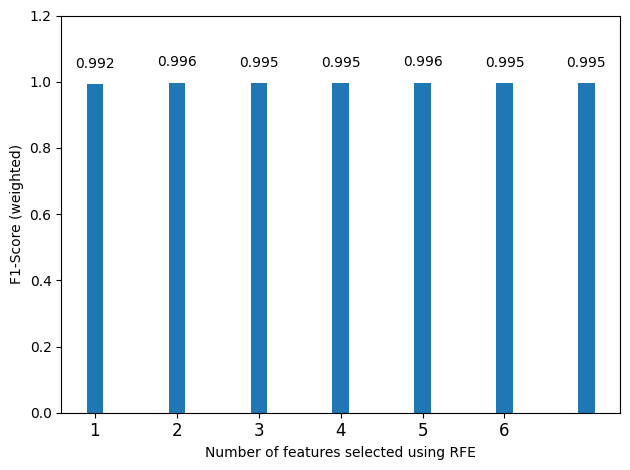

In [52]:
fig, ax = plt.subplots()

x = np.arange(1, 8)
y = rfe_f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using RFE')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 7))
ax.set_xticklabels(np.arange(1, 7), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [53]:
RFE_selector = RFE(estimator=gbc, n_features_to_select=3, step=1)
RFE_selector.fit(X_train_v3, y_train_v3)

selected_features_mask = RFE_selector.get_support()

selected_features = X_train_v3.columns[selected_features_mask]
selected_features

Index(['amount', 'merchant_encoded', 'category_encoded'], dtype='object')

# Boruta

In [54]:
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [55]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
from boruta import BorutaPy

boruta_selector = BorutaPy(gbc, random_state=42)

boruta_selector.fit(X_train_v4.values, y_train_v4.values.ravel())

sel_X_train_v4 = boruta_selector.transform(X_train_v4.values)
sel_X_test_v4 = boruta_selector.transform(X_test_v4.values)

gbc.fit(sel_X_train_v4, y_train_v4)

boruta_preds = gbc.predict(sel_X_test_v4)

boruta_f1_score = round(f1_score(y_test_v4, boruta_preds, average='weighted'), 3)

In [ ]:
selected_features_mask = boruta_selector.support_

selected_features = X_train_v4.columns[selected_features_mask]
selected_features

In [ ]:
fig, ax = plt.subplots()

x = ['All features (13)', 'Variance threshold (11)', 'Filter - MI (3)', 'RFE (3)', 'Boruta (9)']
y = [f1_score_all, f1_score_var, 0.981, 1.0, boruta_f1_score]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0.9, 1)

for i, v in enumerate(y):
    plt.text(x=i, y=v+0.01, s=str(v), ha='center')

plt.tight_layout()

## Adaboost Classifier

In [ ]:
# idk if we even need this though .-.
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [ ]:
X_train_v5, X_test_v5, y_train_v5, y_test_v5 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()